# Sobreajuste, Validación y Regularización


En el ejemplo del **regresor polinomial** vimos que aumentar el grado del polinomio vuelve más flexible al modelo, es decir que aumenta su capacidad para ajustar los datos

:::{note}

La cantidad de parámetros (grados de libertaed) del modelo es un proxy de su complejidad. Un modelo más complejo (más parámetros) es en general más flexible

:::

Sin embargo, si la flexibilidad es excesiva podríamos aproximar ciertos datos con error cero. Esta situación, en que el modelo "memoriza los datos", se conoce como **sobreajuste**

:::{warning}

Un modelo sobreajustado tiende a predecir muy mal datos "que no ha visto", es decir que pierde capacidad de **generalización**

:::

La siguiente figura esquematiza la relación la complejidad o capacidad de ajustar del modelo

<img src="img/overfitting.png" width="400">

Figura: https://www.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html

:::{note}

En general, mientras más simple (menos complejo) sea el modelo, menos propenso es a sobreajustarse

:::

:::{hint}

Podemos evitar el escenario sobreajustado en modelos complejos utilizando un conjunto de datos de validación o estrategias de regularización 

:::

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1234)
x = np.random.randn(30)
y = -0.5*x**4 + 2*x**3 -3 + np.random.randn(len(x))

## Estrategias de Validación

Para combatir el sobreajuste podemos usar **estrategias de validación**, estas se basan en separar el conjunto de datos en dos o más subconjuntos, revisemos dos de ellas

**Holdout**

Consiste en separar los datos en conjuntos de entrenamiento, validación y prueba:

- El primero se ocupa para entrenar o ajustar el modelo
- El segundo se utiliza para detectar sobreajuste y calibrar los hiperparámetros del modelo
- El tercero se ocupa para realizar una evaluación final libre de sesgos

Típicamente, la base de datos se particiona en proporción 80%, 10%, 10% si el dataset es grande o 60%, 20%, 20% si el dataset es pequeño

**K-fold**

La validación cruzada o K-fold consisten en separar el conjunto en $K$ particiones y utilizarlas alternadamente para entrenar y validar como muestra el siguiente esquema

<img src="img/cv.png" width="400">

El caso extremo se conoce como Leave-one-out (LOO), en que se entrena con todos los datos menos uno $N$ veces.


> Para ambos tipos de validación los conjuntos se seleccionan aleatoriamente. También puede hacerse de forma estratificada, es decir manteniendo la proporción de clases


Podemos separar un conjunto en dos con scikit-learn utilizando:

30 24 6


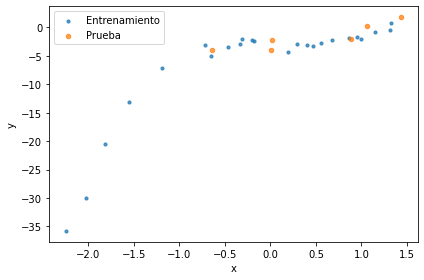

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(y), len(y_train), len(y_test))

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.scatter(X_train, y_train, s=10, label='Entrenamiento', alpha=0.75)
ax.scatter(X_test, y_test, s=20, label='Prueba', alpha=0.75)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y');

En el ejemplo del regresor polinomial podemos utilizar **validación cruzada** para seleccionar el grado de polinomio óptimo

Para esto utilizarmos la función [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Los argumentos de esta función son

- Un modelo de scikit learn
- Datos 
- Etiquetas
- `cv`: La cantidad de particiones (K)
- `scoring`: Una métrica que se utiliza para evaluar el modelo en las particiones

En este ejemplo utilizaremos 5 particiones y el error cuadrático medio como métrica

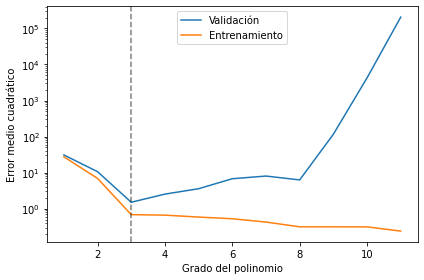

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

val_scores = []
train_scores = []
for degree in range(1, 12):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    scorer = make_scorer(mean_squared_error)
    val_scores.append(cross_val_score(model, X=X_train.reshape(-1, 1), y=y_train, cv=5, scoring=scorer))
    model.fit(X_train.reshape(-1, 1), y_train)
    train_scores.append(mean_squared_error(y_train, model.predict(X_train.reshape(-1, 1))))
    
score_mean = [score.mean() for score in val_scores]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(range(1, 12), score_mean, label='Validación')
ax.plot(range(1, 12), train_scores, label='Entrenamiento')
ax.axvline(3, ls='--', c='k', alpha=0.5)
ax.set_yscale('log')
plt.legend()
ax.set_xlabel('Grado del polinomio')
ax.set_ylabel('Error medio cuadrático');

:::{note}

El regresor polinomial con menor error de validación es de grado 3

:::

En resumen

- Bajo error de entrenamiento y de validación: **Ideal**
- Bajo error de entrenamiento y alto error de validación: **Modelo sobreajustado**
- Alto error de entrenamiento y de validación: Considera un modelo de mayor complejidad y asegurate que tu código no tenga bugs


## Búsqueda de hiperparámetros con scikit-learn

Podemos automatizar aun más la búsqueda de hiperparámetros utilizando [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Los argumentos principales de esta clase son

- Un estimador (regresor o clasificador) de scikit-learn 
- `param_grid`: Un diccionario con los valores de los hiperparámetros que se han de explorar
- `cv`: La cantidad de particiones para la validación cruzada
- `scoring`: Una métrica que se utilizará para evaluar los modelos
- `n_jobs`: El número de núcleos de CPU

El método principal de esta clase es `fit(X, y)` el cual realiza la validación cruzada con todas las combinaciones de hiperparámetros especificadas en `param_grid`

Los principales atributos de la clase son

- `best_estimator_`: Retorna el estimador de mejor desempeño en validación
- `best_params_`: Retorna un diccionario que los hiperparámetros del mejor modelo
- `best_score_`: Retorna el error del mejor modelo

:::{note}

`GridSearchCV` tiene también los métodos `predict` y `predict_proba`, siempre y cuando estos estén implementados en el estimador utilizado. Se retorna la predicción del mejor modelo según la validación cruzada

:::

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV



## Regularización

:::{seealso}

[Una presentación sobre regresión que incluye métodos que no veremos en este curso](https://docs.google.com/presentation/d/1UUpK4zSdzRcS79V7_wU9nXe-sR7qYLEWhbmid-Rfp1k/edit?usp=sharing)

:::